In [1]:
%matplotlib nbagg
import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
dp_end_dates = [datetime.datetime(2022, 6, 1),    # DP0.1
                datetime.datetime(2023, 6, 1),    # DP0.2
                datetime.datetime(2024, 3, 1),    # DP1
                datetime.datetime(2025, 3, 1),    # DP2
                datetime.datetime(2025, 9, 1),    # DR1
                ]

one_year = datetime.timedelta(365)

In [3]:
ops_allocations = {'Computing Environment': 0.6,
                   'Data Verification & Validation': 0.3,
                   'Databases and data access': 0.4,
                   'Image processing pipeline development': 0.75,
                   'Image processing pipeline management': 0.2,
                   'Image simulation development': 1.4,
                   'Image simulation pipeline development': 0,
                   'Image simulation pipeline management': 0,
                   'Science Release management': 0.35,
                   'Software Release management': 0.15
                  }

In [4]:
def get_date(date):
    tokens = date.split('/')
    year = (int(tokens[-1]) % 2000) + 2000
    month = int(tokens[0])
    day = int(tokens[1]) if len(tokens) == 3 else 1
    return datetime.datetime(year, month, day)

In [5]:
def read_sheet(csv_file):
    data = defaultdict(list)
    with open(csv_file) as fobj:
        for line in fobj:
            tokens = line.split(',')
            if (len(tokens[0].split('.')) != 3  #check for a deliverable entry
                or tokens[5] == ''       # skip rows without baseline completion date
                or tokens[14] == ''      # skip rows without Operations role
            ):
                continue
            data['deliverable'].append(tokens[2])
            start = get_date(tokens[4])
            end = get_date(tokens[5])
            data['start'].append(start)
            data['end'].append(end)
            # Assume each PS/CI effort level entry is in FTE-years.
            data['FTE-years'].append(float(tokens[11]))
            # Convert to FTE (as a rate) by dividing by the fraction of a year.
            frac = (end - start)/one_year
            data['FTE'].append(float(tokens[11])/frac)
            data['ops_role'].append(tokens[14])
    return pd.DataFrame(data=data)

<IPython.core.display.Javascript object>


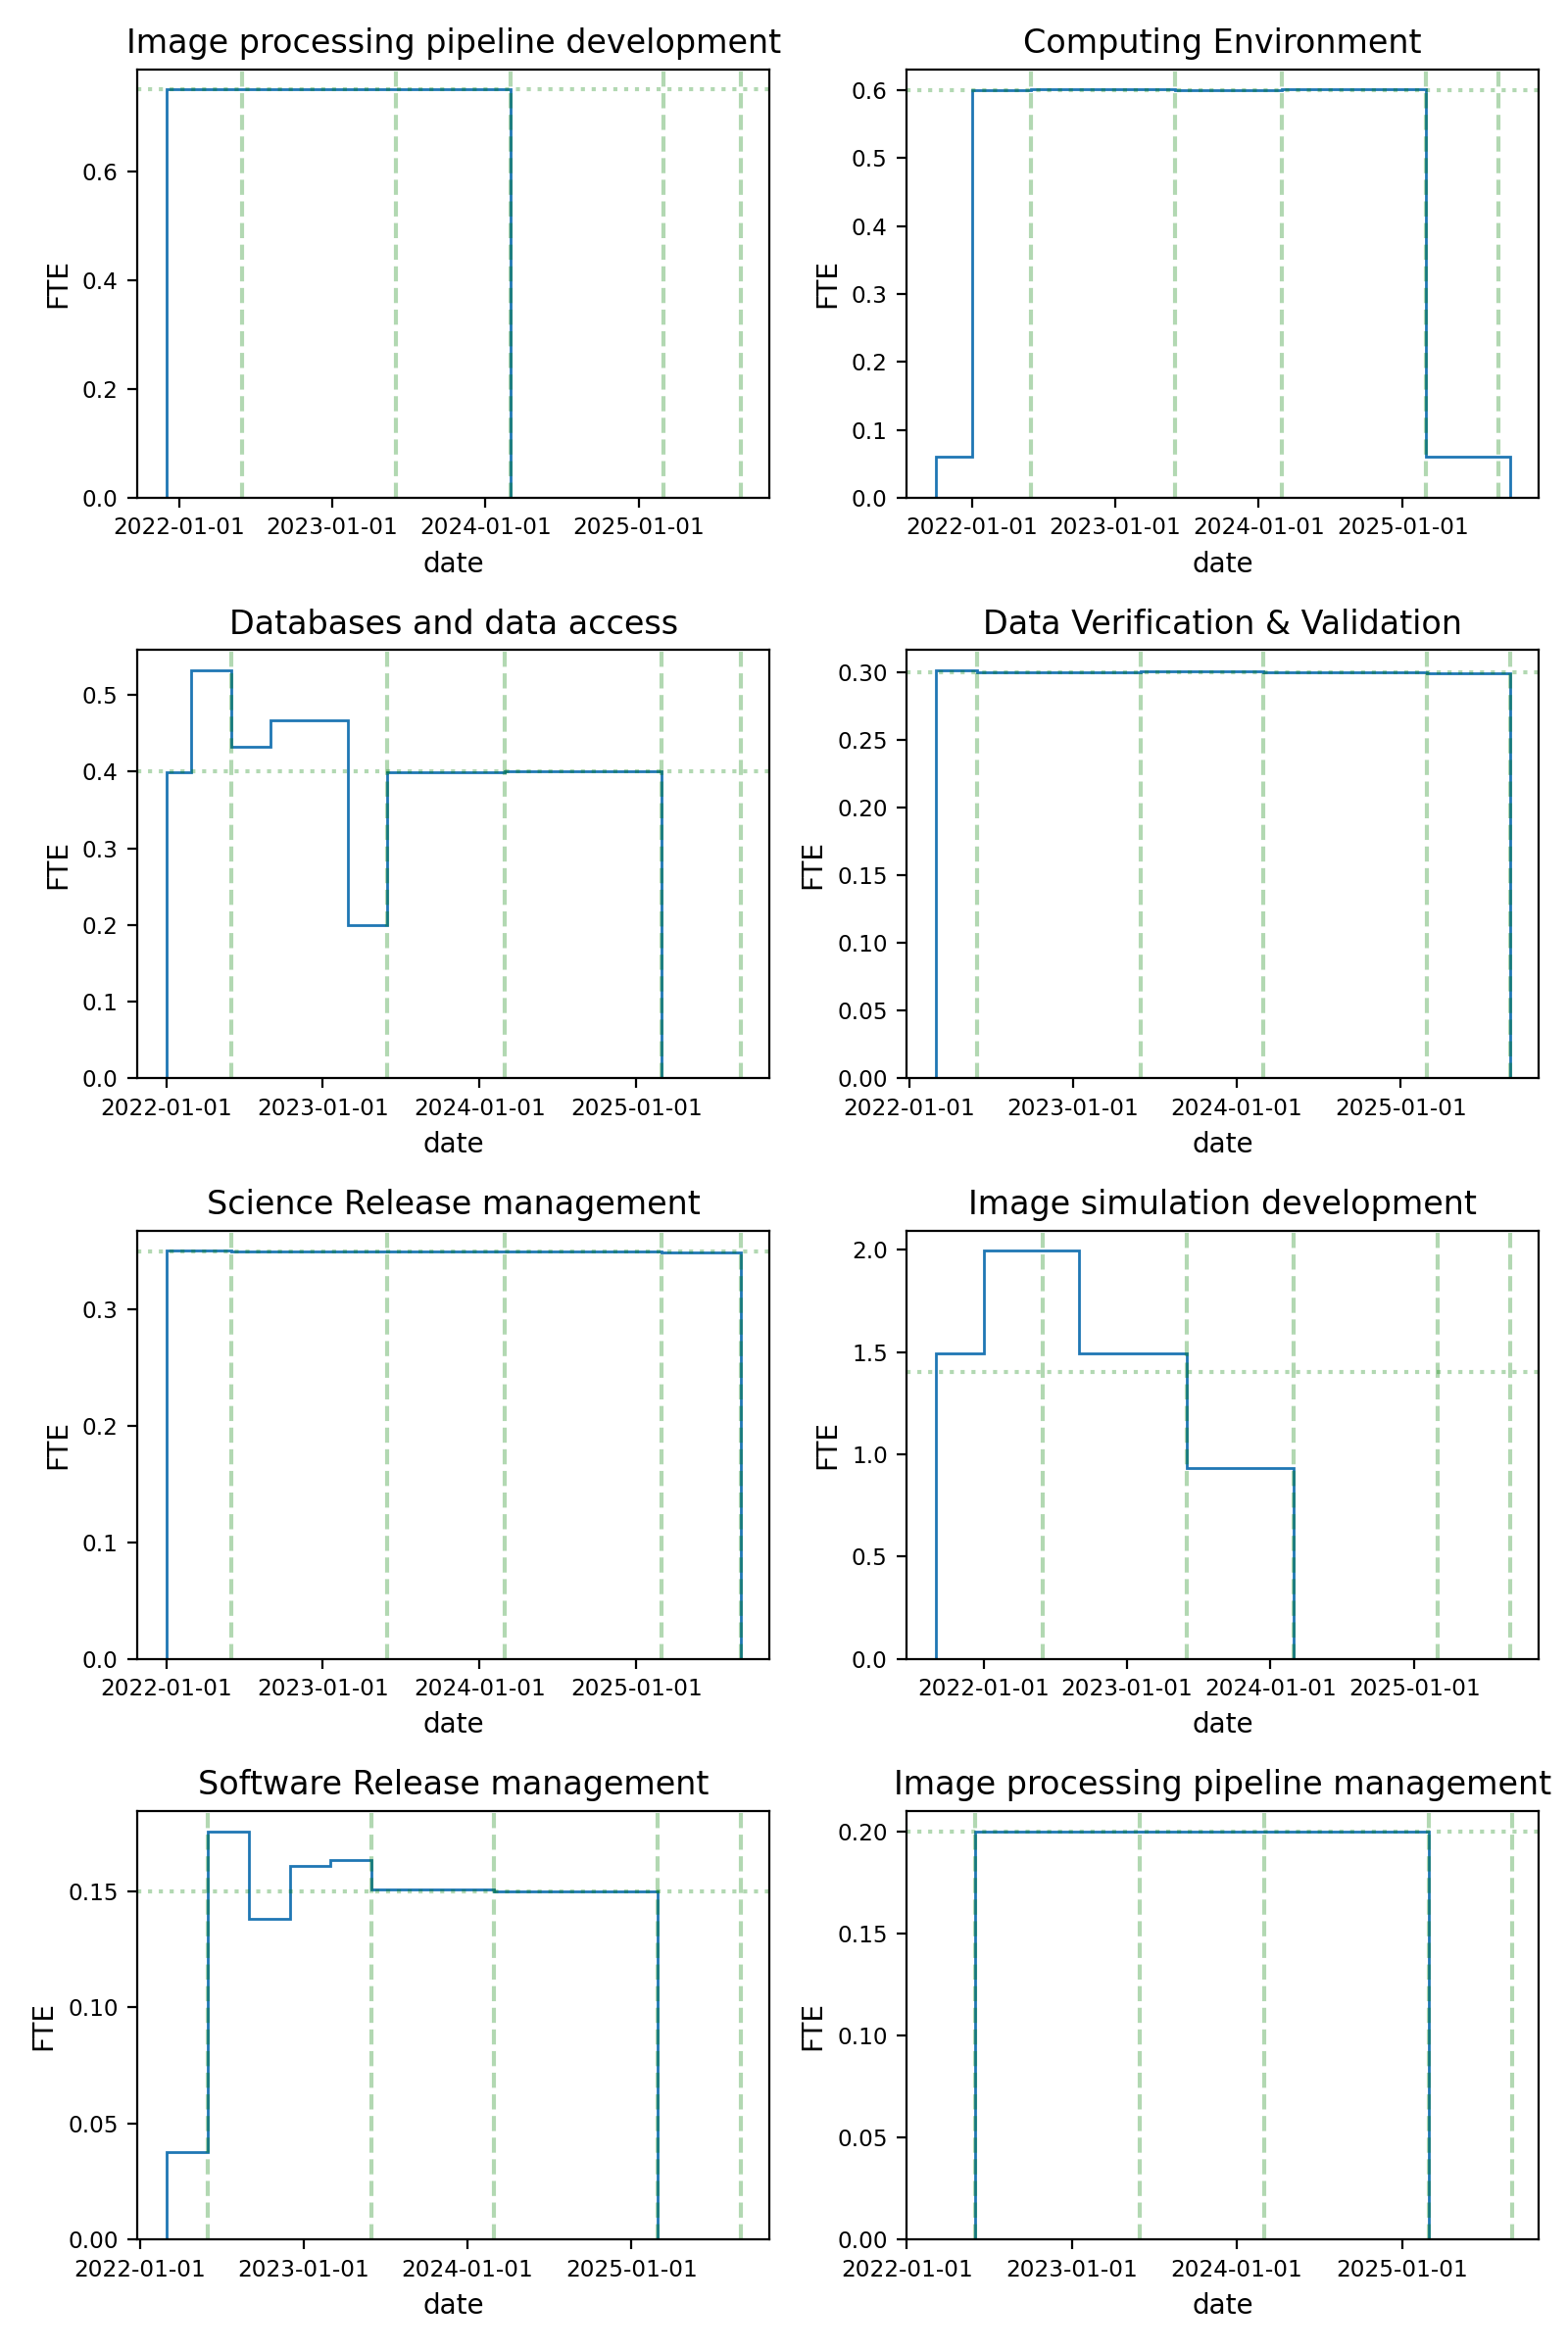

In [6]:
df0 = read_sheet('WBS_Dictionary_Computing.csv')
ops_roles = set(df0['ops_role'])
plt.figure(figsize=(8, 12))
for i, ops_role in enumerate(ops_roles, 1):
    if ops_role == '':
        continue
    plt.subplot(4, 2, i)
    df = df0.query(f'ops_role == "{ops_role}"')
    edges = np.array(sorted(list(set(df['start']).union(df['end']))))
    mid_points = edges[:-1] + (edges[1:] - edges[:-1])/2.
    bin_values = np.zeros(len(mid_points))
    for start, end, fte, fte_years in zip(df['start'], df['end'], df['FTE'], df['FTE-years']):
        for i, mid_point in enumerate(mid_points):
            if start < mid_point < end:
                bin_values[i] += fte
    plt.stairs(bin_values, edges, label=ops_role)
    for dp_end_date in dp_end_dates:
        plt.axvline(dp_end_date, linestyle='--', color='green', alpha=0.3)
    plt.axhline(ops_allocations[ops_role], linestyle=':', color='green', alpha=0.3)
    plt.xticks([datetime.datetime(year, 1, 1) for year in range(2022, 2026, 1)], fontsize='small')
    plt.yticks(fontsize='small')
    plt.title(ops_role)
    plt.ylabel('FTE')
    plt.xlabel('date')
plt.tight_layout()